# Illustration of converting a ABFv1 format ephys file to NWBv2
This notebook goes through an example of converting a single [Axon Binary Format version 1 file (ABFv1)](https://swharden.com/pyabf/abf1-file-format.md.html) into a a single [Neurodata Without Borders version 2 file (NWBv2)](https://nwb-schema.readthedocs.io/en/latest/format.html#intracellular-electrophysiology).

TODO: Stitch together multiple ABFv1 files collected from the same single cell (like for different stimulus protocols) into a single NWBv2 file.

## Clone and import repository for ABFv1 to NWBv2 conversion developed by Young and adapted slightly by Shreejoy

The git clone command commented out below pulls the ABF and NWB code repo from github

In [2]:
#! git clone https://github.com/stripathy/NWB.git # uncomment this if you don't have the repo
from NWB.ABF1Converter import ABF1Converter ### import the converter class

## Define a function that calls the ABFv1 converter class and sets inputs and outputs

The below file takes a single ABFv1 file, a bunch of arguments, and then outputs a single NWBv2 file in a form that can be directly parsed by IPFX tools. 

In [20]:
# import functions
import os
import sys
import glob
import argparse


def abf_to_nwb(inputPath, outFolder, outputMetadata, acquisitionChannelName, stimulusChannelName, overwrite, 
               responseGain = 1.0, stimulusGain = 1.0, responseOffset = 0.0, clampMode = 1):
    """
    Sample file handling script for NWB conversion.

    Takes the path to the ABF v1 file as the first command line argument and writes the corresponding NWB file
    to the folder specified by the second command line argument.

    NWB Files organized by cell, with assumption that each abf file corresponds to each cell
    """

    if not os.path.exists(inputPath):
        raise ValueError(f"The file or folder {inputPath} does not exist.")

    if not os.path.exists(outFolder):
        raise ValueError(f"The file or folder {outFolder} does not exist.")

    # Collect ABF files from the specified directory. 

    if os.path.isfile(inputPath):
        files = [inputPath]
    elif os.path.isdir(inputPath):
        files = glob.glob(inputPath + "/*.abf")
    else:
        raise ValueError(f"Invalid path {inputPath}: input must be a path to a file or a directory")

    if len(files) == 0:
        raise ValueError(f"Invalid path {inputPath} does not contain any ABF files.")

    for inputFile in files:

        fileName = os.path.basename(inputFile)
        root, _ = os.path.splitext(fileName)

        print(f"Converting {fileName}...")

        # Generate name for new NWB file

        outFile = os.path.join(outFolder, root + ".nwb")

        if os.path.exists(outFile):
            if overwrite:
                os.unlink(outFile)
            else:
                raise ValueError(f"The file {outFile} already exists.")

        # Enter each ABF file into the converter script. The additional arguments are meant for command line operations.

        conv = ABF1Converter(inputFile, outFile, 
                             acquisitionChannelName=acquisitionChannelName, stimulusChannelName=stimulusChannelName, 
          responseGain = responseGain,
          stimulusGain = stimulusGain,
          responseOffset = responseOffset, clampMode = clampMode
                            )
        conv.convert()

        if outputMetadata:
            conv._outputMetadata()


## Import metadata from Valiante Lab datasets compiled by Shreejoy

In [42]:
import pandas as pd
import pyabf

# read final csv that has the ouput of metadata gathering process
csv_meta_save_path = 'example_datasets/valiante_lab/cell_final_raw_meta_df.csv'
cell_final_raw_meta_df = pd.read_csv(open(csv_meta_save_path, 'rb'))  

# an example abf file in the example datasets folder

curr_file = '13d02049.abf'
abf_file_path = file_rel_path + curr_file

abf = pyabf.ABF(abf_file_path)
#stim_abf = pyabf.ABF(stim_file_path) # for some files we're using stim traces from a different file

## Get metadata variables that are needed for conversion

Shreejoy comment: these calls are pretty ugly and probably super inefficient
It would be nice to convert these parameter lists to a dictionary or something

In [43]:
# get the row for the cell from the csv file that we just imported
meta_row = cell_final_raw_meta_df.loc[cell_final_raw_meta_df['cell_id'] == curr_file]

num_sweeps = int(meta_row['num_sweeps'].values[0])

stim_channel_num = int(meta_row['stim_chan'].values[0])
response_chan_num = int(meta_row['resp_chan'].values[0])

acq_channel_name = abf.adcNames[response_chan_num]


if stim_name == 'sweepC':
    stim_chan_name = abf.dacNames[stim_channel_num]
else:                  
    stim_chan_name = abf.adcNames[stim_channel_num]

stim_gain = meta_row['stim_gain'].values[0]
if stim_gain == 1000:
    stim_gain = 1.0
response_gain = meta_row['resp_gain'].values[0]

start_time = meta_row['stim_start_time'].values[0]
end_time = meta_row['stim_end_time'].values[0]
resp_sampling_rate = meta_row['resp_sampling_rate'].values[0]
resp_offset = meta_row['resp_offset'].values[0]

responseGain = response_gain
responseOffset = resp_offset
stimulusGain = stim_gain
clampMode = 1 # this is current clamp

## Perform the ABF to NWB conversion!

In [46]:

# sets the folder for output files
outFolder = 'example_datasets/valiante_lab/'
outputMetadata = True

abf_to_nwb(inputPath=abf_file_path,
           outFolder=outFolder,
           outputMetadata=False,
           acquisitionChannelName=acq_channel_name,
           stimulusChannelName=stim_chan_name,
           overwrite=True, 
          responseGain = responseGain,
          stimulusGain = stimulusGain,
          responseOffset = responseOffset, clampMode = clampMode)

Converting 13d02049.abf...
example_datasets/valiante_lab/13d02049.abf


/Users/stripathy/anaconda3/lib/python3.7/site-packages/pynwb/file.py:752: UserWarning: Date is missing timezone information. Updating to local timezone.
  warn("Date is missing timezone information. Updating to local timezone.")
/Users/stripathy/anaconda3/lib/python3.7/site-packages/pynwb/icephys.py:312: UserWarning: Unit 'A' for CurrentClampStimulusSeries 'Index_0_0_0' is ignored and will be set to 'amperes' as per NWB 2.1.0.
  % (current_unit, self.__class__.__name__, name, unit, nwb_version))
/Users/stripathy/anaconda3/lib/python3.7/site-packages/pynwb/icephys.py:312: UserWarning: Unit 'A' for CurrentClampStimulusSeries 'Index_0_1_0' is ignored and will be set to 'amperes' as per NWB 2.1.0.
  % (current_unit, self.__class__.__name__, name, unit, nwb_version))
/Users/stripathy/anaconda3/lib/python3.7/site-packages/pynwb/icephys.py:312: UserWarning: Unit 'A' for CurrentClampStimulusSeries 'Index_0_2_0' is ignored and will be set to 'amperes' as per NWB 2.1.0.
  % (current_unit, self._

/Users/stripathy/anaconda3/lib/python3.7/site-packages/hdmf/build/objectmapper.py:233: DtypeConversionWarning: Spec 'CurrentClampSeries/sweep_number': Value with data type int64 is being converted to data type uint64 (min specification: uint32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Users/stripathy/anaconda3/lib/python3.7/site-packages/hdmf/build/objectmapper.py:233: DtypeConversionWarning: Spec 'CurrentClampSeries/sweep_number': Value with data type int64 is being converted to data type uint64 (min specification: uint32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Users/stripathy/anaconda3/lib/python3.7/site-packages/hdmf/build/objectmapper.py:233: DtypeConversionWarning: Spec 'CurrentClampSeries/sweep_number': Value with data type int64 is being converted to data type uint64 (min specification: uint32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Users/stripathy/anaconda3/lib/python3.7/site-packages/hdmf/build/objectmapper.py:233: D

/Users/stripathy/anaconda3/lib/python3.7/site-packages/hdmf/build/objectmapper.py:233: DtypeConversionWarning: Spec 'CurrentClampStimulusSeries/sweep_number': Value with data type int64 is being converted to data type uint64 (min specification: uint32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Users/stripathy/anaconda3/lib/python3.7/site-packages/hdmf/build/objectmapper.py:233: DtypeConversionWarning: Spec 'CurrentClampStimulusSeries/sweep_number': Value with data type int64 is being converted to data type uint64 (min specification: uint32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Users/stripathy/anaconda3/lib/python3.7/site-packages/hdmf/build/objectmapper.py:233: DtypeConversionWarning: Spec 'CurrentClampStimulusSeries/sweep_number': Value with data type int64 is being converted to data type uint64 (min specification: uint32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Users/stripathy/anaconda3/lib/python3.7/site-packages/hdmf/buil

/Users/stripathy/anaconda3/lib/python3.7/site-packages/hdmf/build/objectmapper.py:233: DtypeConversionWarning: Spec 'CurrentClampSeries/sweep_number': Value with data type int64 is being converted to data type uint64 (min specification: uint32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Users/stripathy/anaconda3/lib/python3.7/site-packages/hdmf/build/objectmapper.py:233: DtypeConversionWarning: Spec 'CurrentClampSeries/sweep_number': Value with data type int64 is being converted to data type uint64 (min specification: uint32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Users/stripathy/anaconda3/lib/python3.7/site-packages/hdmf/build/objectmapper.py:233: DtypeConversionWarning: Spec 'CurrentClampSeries/sweep_number': Value with data type int64 is being converted to data type uint64 (min specification: uint32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Users/stripathy/anaconda3/lib/python3.7/site-packages/hdmf/build/objectmapper.py:233: D

Successfully converted to example_datasets/valiante_lab/13d02049.nwb.


## Illustrate loading of converted NWB dataset into IPFX

In [47]:
from ipfx.dataset import hbg_nwb_data
from ipfx.data_set_features import extract_data_set_features
from ipfx.dataset.create import create_ephys_data_set
import ipfx

In [48]:
nwb_file_name = outFolder + '13d02049.nwb'
print(nwb_file_name)
data_set = create_ephys_data_set(nwb_file=nwb_file_name) ##loads the NWB as an HBG dataset, Equal to the nwb1.0 -> AIBS dataset

#data_set = hbg_nwb_data.HBGNWBData(nwb_file=nwb_file_name, ontology = ipfx.) ##loads the NWB as an HBG dataset, Equal to the nwb1.0 -> AIBS dataset

example_datasets/valiante_lab/13d02049.nwb


In [49]:
# this doesn't work? why?
pd.DataFrame(data_set.extract_sweep_stim_info())

AttributeError: 'EphysDataSet' object has no attribute 'extract_sweep_stim_info'

## Illustrate plotting of a sweep with IPFX tools

/Users/stripathy/anaconda3/lib/python3.7/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/stripathy/anaconda3/lib/python3.7/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


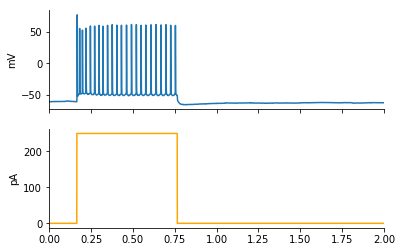

In [50]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ipfx.sweep import Sweep, SweepSet

sweep_plot_index = 13
curr_sweep = data_set.sweep_set([0, 13]).sweeps[1]
t = curr_sweep.t
v = curr_sweep.v
i = curr_sweep.i

fig, axes = plt.subplots(2, 1, sharex=True)

axes[0].plot(t, v)
axes[0].set_xlim(0, 2)
axes[0].set_ylabel("mV")

axes[1].plot(t, i, c="orange")
axes[1].set_ylabel("pA")

sns.despine()